<a href="https://colab.research.google.com/github/tonyscan6003/CE5021_AY2526_group1/blob/pionicolafiano_ce5021/Assignment2_student_PioNicolaFiano_sem1_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with Med MNIST.

In this assignment you will use transfer learning to train a model of your choice on a sub-dataset from the [MedMNIST datasets](https://medmnist.com/). ![](https://github.com/tonyscan6003/etivities/blob/main/medmnist.JPG?raw=true)

* The [MedMNIST package](https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb) allows the data to be imported directly as a pytorch dataset.

* You may select any of the datasets using Multi-class/binary classification. The goal is to acheve accuracy levels comparable to the benchmark results shown on the medmnist site. Dataloading for pytorch is setup in the notebook, you wil need to modify the code slightly depending on your dataset of choice.

* Some datasets use black and white images, so you will need to [at least concatenate](https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a) the input image channels (to 3 channels) for compatibility with the models pre-trained on imageNet.

* Some of the MedMNIST datasets don't contain too much data so Data augmentation may be essentila essential to avoid overfitting. In pytorch data augmentation is performed using the [transforms.v2](https://pytorch.org/vision/main/transforms.html) modules.

* In this notebook: You will need to import a model, and perform training. Tranfer Learning for computer vision is detailed [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

* [Tensorboard can be imported](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) to display results.

* Please only include one example of transfer learning in the submitted notebook. Making sure training curves/results are clearly visible. If you have trained additional transfer learning models (i.e. that were less successful) please add this as a table or report at the end of the notebook and/or in your final forum post.




# 1. Install & Import Packages

In [3]:
!pip install medmnist
!pip install torchinfo

In [4]:
import torch
from torch import nn
from torchvision import datasets, models
from torchvision.transforms import ToTensor, Pad, Grayscale
import torchvision.transforms.v2 as v2 # Corrected import for v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

## 2. Setup & Import Dataset
The [MedMNSIT](https://medmnist.com/) package (imported above) makes available several medical datasets available to access.

You can change the `data_flag` variable (dataset names are all lower case letters) to the dataset of your choice (Take care to note the parameters e.g. number of input channels below that will affect your model)



In [5]:
import medmnist
from medmnist import INFO, Evaluator

#data_flag = 'bloodmnist'
data_flag = 'pathmnist'
download = True

BATCH_SIZE = 64

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print('Type of Machine Learning Task = ',task)
print('Number of Input Data Channels = ',n_channels)
print('Number of Classes = ',n_classes)
print('The batch size for this dataset will be = ',BATCH_SIZE)

DataClass = getattr(medmnist, info['python_class'])

Type of Machine Learning Task =  multi-class
Number of Input Data Channels =  3
Number of Classes =  9
The batch size for this dataset will be =  64


Transforms:
You can update the functions below with appropriate transforms for your particular use case.

* As well as being suitable for data augmention for image classification, the transforms.v2 package of torchvision extends transforms for object detection and segmentation tasks. An illustration of the transforms is shown [here](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).
* Normalisation based on ImageNet parameters is included already. This should be used with all models pre-trained on ImageNet  





In [135]:
train_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])


test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [6]:
from torchvision import transforms as T

train_transforms = v2.Compose([
    v2.Resize((224, 224)),                  # Resize 28x28 → 224x224
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(15),
    ToTensor(),                          # Converts to float32 and scales to [0,1]
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

test_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ToTensor(),
    v2.Normalize([0.485, 0.456, 0.406],
                 [0.229, 0.224, 0.225]),
])

Setup your Medmnist dataset.
* The convolution part of pre-trained networks (such as resnet) are compatable with any size input image (A convolution layer slides a kernel over the height and width of an image. A 3×3 kernel does the same operation whether the input is 64×64, 224×224, or 512×800. The number of weights (parameters) in the kernel stays the same no matter how large the input is. But, even though the kernel parameters don’t change, the output feature map does change.
). However they were trained on 224 x 224 size images, with early layers finding small scale features and deeper layers finding large scale features.
* For this transfer learning application to medical data, **the gap between the original ImageNet domain and the medical images is wide**. Therefore the size/scale of the input images is less important, however in general we would expect better performance with the larger input images (as they contain more features at different scales).
* You can add the `size=224` parameter to the dataset object calls, to load full size images. Only do this once you are confident in your training methodology (or if the dataset is small), as training with full size images will take longer.

ResNet (and similar CNNs) are pre-trained on ImageNet. Characteristic:
* natural images
* RGB
* many textures
* objects, animals, outdoor scenes

Medical images, depending on modality, are:
* grayscale or non-RGB distributions
* highly homogeneous textures
* anatomical structures instead of natural patterns
* much more subtle local features
* often very different contrast (low contrast), noise (e.g. unwanted random variation in pixel values), and scale properties (see Literature Review section below)

*This domain gap is huge!*

Because of this gap, the low-level ImageNet filters (edges, corners, color blobs) still transfer, but the higher-level object-specific filters transfer poorly.

→ *This makes the exact input resolution less crucial than we might expect, compared to natural images!*

If the semantics change drastically, resizing from 224 → 384 → 512 does not fundamentally “restore” ImageNet-style features.

**Semantics** = the meaning of the content in the image.

Examples of semantic content:
* A dog → fur, legs, head
* A car → wheels, metal surfaces
* A lung X-ray → ribs, soft tissue, air spaces
* An MRI → brain structures, gray matter, lesions
*Semantics = what the image is, not how big it is.*, therefore resizing cannot change the semantics

ImageNet models learned high-level concepts such as:
* fur texture
* animal eyes
* wheels
* buildings
* grass
* sky

A medical image contains none of these.

So even if we feed a larger image (384/512), the pre-trained model:
* still sees completely different patterns
* still activates filters designed for natural images
* still has mismatched high-level feature detectors

Resizing improves resolution, but does not change the underlying domain mismatch.

To summarize: *Increasing image resolution helps preserve detail, but it cannot make a medical image behave like a natural ImageNet image, because the underlying content (semantics) is entirely different*

**Literature Review**
1. Contrast differences

**Contrast** = differences in brightness between regions.

*ImageNet / natural images*

High contrast (bright skies, dark shadows)

Color variation (RGB)

Objects clearly separated from backgrounds

Example: A dog on the grass → clear boundaries, strong textures, color differences.

*Medical images*

Often low contrast

X-rays: many shades of grey with subtle differences

Ultrasound: soft transitions, lots of haze

MRI: tissues differ only slightly in intensity

No color channels → grayscale or custom modality (CT HU units, MRI T1/T2 weighting)

--> *Interpretation is harder because abnormalities may differ by only 1–5% pixel intensity.*

2. Noise differences

**Noise** = unwanted random variation in pixel values.

*Natural images*

Usually clean

Noise mainly from low light or bad camera quality

Cameras produce RGB sensor noise, which has specific patterns

*Medical images*

Each modality introduces its own type of noise:

Modality	Typical noise
X-ray: photon noise, scattering artifacts
MRI	Gaussian: Rician noise
Ultrasound: speckle noise (grainy texture)
CT scan: Poisson noise, reconstruction artifacts

These noise patterns look nothing like the noise ImageNet models are used to learning.

--> *CNNs trained on ImageNet may misinterpret medical noise as texture or edges.*

3. Scale differences

**Scale** = the size of meaningful features in the image.

*ImageNet images*

Objects appear at many scales

a dog can fill the whole frame

a bird can be small

Backgrounds vary widely

Scale is inconsistent → good for CNN generalization

*Medical images*

Organs and anatomical structures have consistent, fixed scales

the size of a lung

the shape of a vertebra

the thickness of skin layers

Abnormalities may be extremely small

microcalcifications

tiny lesions

hairline fractures

--> *CNNs must be sensitive to fine details, whereas ImageNet models aren’t optimized for such tiny-scale patterns.*

**Why these differences matter for transfer learning**

ResNet50 learned filters on *ImageNet* that expect:
* strong edges
* vibrant colors
* high contrast
* natural textures (grass, fur, wood, sky)
* objects that vary in size

In medical imaging, it encounters:
* weak edges
* grayscale
* subtle shape changes
* faint lesions
* fixed anatomical scales
* modality-specific noise

This is why the domain shift is huge, pre-trained features can still help, but not as strongly as in natural-image tasks.

To summarize: *Medical images differ from ImageNet images in contrast (how bright/dark features appear), noise (the type of grain or artifacts present), and scale (the typical size of structures and abnormalities), which makes transfer learning less straightforward.*

1. MedMNIST datasets do not store large images by default.
Most are very small, e.g.:
* PathMNIST → 28×28
* OrganMNIST → 28×28
* ChestMNIST → 28×28
* RetinaMNIST → 28×28 (grayscale)

When I write: train_dataset = DataClass(split='train', size=224, ...)

I tell MedMNIST: “Load the images AND resize them to 224×224 for me.”

This is done *before transforms*, so the images are now:
* bigger
* higher-resolution (synthetically)
* compatible with ImageNet models, which expect 224×224 input

2. Why use 224×224 at all?

Because ImageNet models (ResNet, EfficientNet, etc.) were trained at 224×224.

If my medical images are kept at 28×28:
* they contain very little detail
* ResNet must massively downsample them (stride 2 convs)
* the model sees almost no spatial information
* performance will likely be poor

So resizing to 224×224:
* makes the network behave as intended
* preserves more detail (even though upsampled)
* produces larger feature maps at deeper layers
* improves transfer-learning accuracy

In [7]:
download = True # Changed to True to ensure data download if not present
# Download training data from open datasets.
train_dataset = DataClass(split='train', transform=train_transforms, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(split='test', transform=test_transforms, download=download, size=224, mmap_mode='r')
val_dataset = DataClass(split='val', transform=test_transforms, download=download, size=224, mmap_mode='r')

#mmap_mode='r' --> Load the dataset from disk using memory-mapped mode, read-only.
#size=224 --> It tells MedMNIST: "Resize every image to 224×224 pixels." Why? Because ImageNet pre-trained models expect 224×224 images.
#If omitted, many MedMNIST datasets default to 28×28
#download=download If download=True, MedMNIST will: download the dataset from the official repository, store it locally, avoid re-downloading if already cached

The `Dataset` is passed as an argument to `DataLoader`. This wraps an
iterable over the dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading.

In [8]:
# Create data loaders.
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64, 1]) torch.int64


Plot some example augmented images

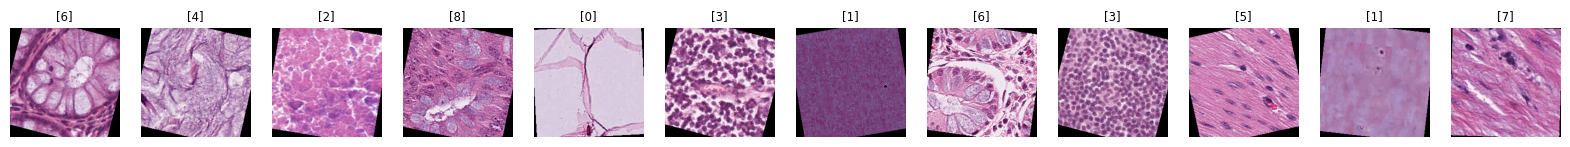

In [9]:
# Output next batch from dataloader
dataiter = iter(train_dataloader)
image_batch, labels_batch = next(dataiter)

# Use matplotlib to plot a sample of images

i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image,(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  axarr[i].set_title(labels_batch[i].numpy(),fontsize='small')
  i = i+1


# 3. Define Transfer Learning model
Pytorch has an inbuilt [models package](https://pytorch.org/vision/stable/models.html) that allows loading of popular models with pre-trained weights.

* We want to add an additional classifier stage (to the output of the network). How to setup the [model is detailed here](https://discuss.pytorch.org/t/load-only-a-part-of-the-network-with-pretrained-weights/88397/2).
* This additional classifier may just be a single layer or a cascade of fully connected layers with dropout.
* Note that the number of parameters in the convolutional part of the model will be same no what the input size is set to. However the output feature map size will vary with input image size (small for small image, large for large image). This means the number of parameters in the additional classifier will change depending on input image size.


In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [11]:
from torchvision.models import resnet50, ResNet50_Weights

In [17]:
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, 9)
)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

optimizer = torch.optim.SGD(
    model.fc.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

# 5. Create optimizer AFTER freezing
#optimizer = torch.optim.AdamW(
#    model.fc.parameters(),  # only train the head
#    lr=3e-4,
#    weight_decay=1e-4
#)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.0.conv3.weight False
layer1.0.bn3.weight False
layer1.0.bn3.bias False
layer1.0.downsample.0.weight False
layer1.0.downsample.1.weight False
layer1.0.downsample.1.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer1.1.conv3.weight False
layer1.1.bn3.weight False
layer1.1.bn3.bias False
layer1.2.conv1.weight False
layer1.2.bn1.weight False
layer1.2.bn1.bias False
layer1.2.conv2.weight False
layer1.2.bn2.weight False
layer1.2.bn2.bias False
layer1.2.conv3.weight False
layer1.2.bn3.weight False
layer1.2.bn3.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2

In [104]:
# Optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

In [18]:
from torchvision.models import resnet50, ResNet50_Weights

*resize_size=[232]*

The pipeline will resize the input image so that the shorter side is 232 pixels (preserving aspect ratio).

(Behaviour: when size is an int in Resize, torchvision typically resizes the smaller edge to that value, keeping aspect ratio.)

This step increases/decreases the raw image size while keeping aspect ratio so the subsequent crop has the expected field of view.

*crop_size=[224]*

After resizing, the pipeline applies a center crop of size 224×224.

The model was trained on center-cropped 224×224 images, so this replicates training preprocessing.

Why resize to 232 then crop to 224?

Resizing the short side to a slightly larger number (232) and then center-cropping 224 is a standard ImageNet convention: it reduces the effect of small translations while maintaining a consistent crop area that the model saw in training.

*mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]*

These are the per-channel ImageNet normalization statistics (RGB order).

After converting image pixels to floating values in [0,1], the pipeline subtracts the mean and divides by the std for each channel:

x_norm[c] = (x[c] - mean[c]) / std[c]

This centers and scales each channel to have similar distributions the model expects.

*interpolation=InterpolationMode.BILINEAR*

When resizing, bilinear interpolation is used to compute new pixel values (smooth, good general-purpose choice).

Interpolation affects how details change when resizing; bilinear is commonly used for photos and model training.

# 4. Optimisation & Training Loop

Define a training loop that prints the loss from the training and validation set at least every epoch.
* You may choose to make the validation loss calculations more frequent so you can ensure training is progressing satisfactorily (especially with larger datasets).

* You can use tensorboard to visualise the [loss curves](https://pytorch.org/docs/stable/tensorboard.html))

* For multi-class classification classification problem we will use the  [CrossEntropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). In this pytorch function, the input is the un-normalised logit value.

* You may  have to use [torch.squeeze](https://pytorch.org/docs/stable/generated/torch.squeeze.html) to reduce the dimensionality of the label tensor before passing it to the loss function (this due to how the dataset is configured and the loss will only accept 0D or 1D inputs)

Initialise Tensorboard (use of tensorboard in colab notebooks is [detailed here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb)). A [Pytorch tutorial](https://pytorch.org/tutorials/beginner/introyt/tensorboardyt_tutorial.html) shows how to setup the training and validation loop with pytorch.


In [19]:
!pip install tensorboard

In [20]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs')

In [21]:
# --- Loss Function ---
loss_fn = nn.CrossEntropyLoss()

# --- Optimizer: only classifier parameters ---
#optimizer = torch.optim.AdamW(
#    model.classifier.parameters(),   # new classifier head layers only
#    lr=3e-4,
#    weight_decay=1e-4
#)

In [22]:
# -------------------------
# Early Stopping Class
# -------------------------
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss

        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} / {self.patience}")

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_loss = val_loss
            self.counter = 0


In [115]:
pretrained = models.resnet50(weights=ResNet50_Weights.DEFAULT)
class MedMNIST_Classifier(nn.Module):
    def __init__(self, pretrained_model, num_classes=9):
        super(MedMNIST_Classifier, self).__init__()
        self.weights = pretrained_model

        for param in self.weights.parameters():
            param.requires_grad=False

        in_features = self.weights.fc.in_features
        self.weights.fc = nn.Sequential(
            nn.Linear(in_features, 100),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = self.weights(x)
        return x

model = MedMNIST_Classifier(pretrained_model=pretrained, num_classes = 9)


def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {frozen_params:,}")


count_parameters(model)

Total parameters: 23,713,841
Trainable parameters: 205,809
Frozen parameters: 23,508,032


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Basic loop
num_epochs = 20

for epoch in tqdm(range(num_epochs)):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    # ---- TRAINING PHASE ----
    model.train()  # set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = torch.squeeze(labels)  # make sure labels are 1D

        optimizer.zero_grad()           # clear old gradients
        outputs = model(inputs)  # forward pass
        loss = criterion(outputs, labels)    # compute loss
        loss.backward()                     # backpropagation
        optimizer.step()                    # update weights

        running_loss += loss.item()

        # --- Track training accuracy ---
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels)
        total_train += labels.size(0)

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct_train.double() / total_train
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}")

    # ---- VALIDATION PHASE ----
    model.eval()  # set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # no gradient calculation in validation
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = torch.squeeze(labels)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

    val_loss = val_loss / len(val_dataloader)
    val_acc = correct.double() / total

    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")
        # ---- TENSORBOARD LOGGING ----

    writer.add_scalars(
        'Loss',
        {'Training Loss': train_loss, 'Validation Loss': val_loss},
        epoch
    )
    writer.add_scalars(
        'Accuracy',
        {'Training Acc': train_acc, 'Validation Acc': val_acc},
        epoch
)

writer.close()

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
--------------------


KeyboardInterrupt: 

In [ ]:
n_iter = 10
n_epochs = 10
train_size = len(train_dataloader.dataset)
test_size = len(test_dataloader.dataset)
num_test_batches = len(test_dataloader)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=n_epochs,
    eta_min=1e-6
)

# -------------------------
# Initialize Early Stopping
# -------------------------
early_stopper = EarlyStopping(patience=5, min_delta=0.001)

best_vloss = np.inf

# --- Training Loop ---
for epoch in range(n_epochs):

    # Reset patience at the beginning of each epoch
    early_stopper.counter = 0
    early_stopper.early_stop = False

    running_loss = 0.0
    running_acc = 0.0
    model.train()

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        labels = torch.squeeze(labels)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += (outputs.argmax(1) == labels).float().sum().item()

        # ------- Validation Step -------
        if i % n_iter == n_iter - 1:
            print(f'Epoch {epoch}  Batch {i+1}')

            model.eval()
            running_vloss = 0.0
            running_vacc = 0.0

            with torch.no_grad():
                for vinputs, vlabels in test_dataloader:
                    vinputs, vlabels = vinputs.to(device), vlabels.to(device)
                    vlabels = torch.squeeze(vlabels)

                    voutputs = model(vinputs)
                    vloss = loss_fn(voutputs, vlabels)

                    running_vloss += vloss.item()
                    running_vacc += (voutputs.argmax(1) == vlabels).float().sum().item()

            model.train()

            avg_loss = running_loss / n_iter
            avg_acc = 100 * running_acc / (n_iter * BATCH_SIZE)

            avg_vloss = running_vloss / num_test_batches
            avg_vacc = 100 * running_vacc / test_size

            running_loss = 0.0
            running_acc = 0.0

            print(f"Training Error:\n Accuracy: {avg_acc:>0.1f}%, Loss: {avg_loss:.6f}")
            print(f"Valid Error:\n Accuracy: {avg_vacc:>0.1f}%, Loss: {avg_vloss:.6f}\n")

            writer.add_scalars('Loss',
                               {'Training Loss': avg_loss, 'Validation Loss': avg_vloss},
                               epoch * len(train_dataloader) + i)
            writer.add_scalars('Accuracy',
                               {'Training Acc': avg_acc, 'Validation Acc': avg_vacc},
                               epoch * len(train_dataloader) + i)

            # -------------------------
            # Early Stopping Check
            # -------------------------
            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                torch.save(model.state_dict(), "best_model.pth")
                print("Saved new best model\n")

            early_stopper(avg_vloss)
            if early_stopper.early_stop:
                print("Early stopping triggered!")
                model.load_state_dict(torch.load("best_model.pth"))
                print("Restored best model.")
                writer.flush()
                break

    scheduler.step()

print("Finished Training")
writer.flush()


Epoch 0  Batch 10
Training Error:
 Accuracy: 86.1%, Loss: 0.451205
Valid Error:
 Accuracy: 83.7%, Loss: 0.647678

Saved new best model

Epoch 0  Batch 20
Training Error:
 Accuracy: 89.7%, Loss: 0.366125
Valid Error:
 Accuracy: 88.4%, Loss: 0.417605

Saved new best model

Epoch 0  Batch 30
Training Error:
 Accuracy: 90.3%, Loss: 0.302372
Valid Error:
 Accuracy: 88.1%, Loss: 0.392931

Saved new best model

Epoch 0  Batch 40
Training Error:
 Accuracy: 91.6%, Loss: 0.250845
Valid Error:
 Accuracy: 88.3%, Loss: 0.382443

Saved new best model

Epoch 0  Batch 50
Training Error:
 Accuracy: 92.5%, Loss: 0.240408
Valid Error:
 Accuracy: 88.5%, Loss: 0.357500

Saved new best model

Epoch 0  Batch 60
Training Error:
 Accuracy: 92.8%, Loss: 0.220074
Valid Error:
 Accuracy: 88.0%, Loss: 0.371359

EarlyStopping counter: 1 / 5
Epoch 0  Batch 70
Training Error:
 Accuracy: 93.9%, Loss: 0.205786
Valid Error:
 Accuracy: 86.2%, Loss: 0.397113

EarlyStopping counter: 2 / 5
Epoch 0  Batch 80
Training Error:


In [ ]:
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs --bind_all

# 5. Evaluate Model
You will need to setup an evaluation loop for the model to assess it's performance on the test dataset.

You may also obtain a classification report after final evaluation of the test dataset with the model using the code below. A confusion matrix can also be obtained and we will plot a few example images.



In [ ]:
classes = [
    "background",
    "adipose",
    "debris",
    "lymphocytes",
    "epithelial",
    "stromal",
    "muscle",
    "mucus",
    "necrosis",
]

store_predictions = []
store_labels = []
model.eval()

for i, data in enumerate(test_dataloader, 0):
    # basic training loop
    input_batch, label_batch = data
    input_batch = input_batch.to(device)

    pred_logit = model(input_batch)
    predictions = torch.argmax(pred_logit,1) # reduce along output dimension
    predictions_np = predictions.to("cpu").numpy()
    label_batch_np = label_batch.numpy()
    if i<num_test_batches-1:
      store_predictions.append(predictions_np)
      store_labels.append(label_batch)

y_pred = np.squeeze(np.reshape(store_predictions,(1,(num_test_batches-1)*BATCH_SIZE)))
y_true = np.squeeze(np.reshape(store_labels,(1,(num_test_batches-1)*BATCH_SIZE)))

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=classes))

In [ ]:
# Output next batch from dataloader
dataiter = iter(test_dataloader)
image_batch, labels_batch = next(dataiter)

# Pass batch through model
model.eval()
image_batch = image_batch.to(device)
pred_logit = model(image_batch)


# Use matplotlib to plot a sample of images
import matplotlib.pyplot as plt
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))


for image in image_batch[0:n_plots,:,:,:]:
  disp_image =  torch.permute(image.to('cpu'),(2,1,0)).numpy() # return image to cpu for display and permute to channels last
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  disp_image = std * disp_image + mean
  disp_image = np.clip(disp_image, 0, 1)
  axarr[i].imshow(disp_image[:,:,:])
  axarr[i].axis("off")
  predicted, actual = classes[pred_logit[i,:].argmax(0)], classes[labels_batch[i]]
  color = 'black' if predicted == actual else 'red'
  axarr[i].set_title(predicted,fontsize='small', color=color)
  i = i+1

 # Comments about your Approach